# Ejercicio 6: Monte Carlo

Importar gym y GymRecorder

In [ ]:
  !pip install -U gymnasium pygame moviepy
  !pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 836 kB 5.2 MB/s 
     |████████████████████████████████| 21.8 MB 4.9 MB/s 
     |████████████████████████████████| 388 kB 23.6 MB/s 
     |████████████████████████████████| 26.9 MB 1.7 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110742 sha256=72e51a8b7b6537cc9c1471b6afa664d58f3ad8dc4d1b5110d709c2bfc1bf5859
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 60 kB/s 
     |████████████████████████████████| 1.8 MB 36.5 MB/s 
     |█

In [ ]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import os

import gymnasium as gym
print("gym version:", gym.__version__)

from moviepy.editor import ImageSequenceClip, ipython_display

class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.

    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=1)
        del self._frames
        self._frames = []

gym version: 0.26.3



En este ejercicio vamos a aplicar métodos de Monte-Carlo al entorno Taxi disponible en gym:

https://gymnasium.farama.org/environments/toy_text/taxi/

Creemos a continuación el entorno en modo ansi y mostremos el primer estado:

In [ ]:
env = gym.make("Taxi-v3", render_mode='ansi')
state, info = env.reset()
print(state)
print(env.render())

133
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




El agente es el cuadrado verde. Se puede mover hacia arriba, abajo, izquierda o derecha si es que no hay una pared (| y :). El objetivo es recoger a los clientes en la posición azul y dejarlos en la posición morada. Estas ubicaciones están fijas (R, G, B, Y), pero cambia cual es el lugar de recogida y de destino entre episodios.


**Pregunta 1** Vuelva a correr el código anterior múltiples veces para observar distintos estados iniciales.



Veamos ahora el espacio de estados:

In [ ]:
print("Espacio de acciones:", env.action_space)
print("Número de acciones:", env.action_space.n)

Espacio de acciones: Discrete(6)
Número de acciones: 6


Hay 6 acciones: sur, norte, este, oeste, recoger, entregar.

Veamos el espacio de estados

In [ ]:
print("Espacio de estados:", env.observation_space)
print("Número de estados:", env.observation_space.n)

Espacio de estados: Discrete(500)
Número de estados: 500



El taxi puede estar en cualquier ubicación de la grilla de 5x5, dando 25 lugares diferentes..
El pasajero puede estar en cualquiera de las 4 ubicaciones R, G, B, Y o ya en el taxi: 5 valores.
El destino puede ser cualquiera de las 4 ubicaciones: 4 valores.
Esto nos da 25x5x4 = 500 combinaciones diferentes.

La representación interna de un estado es un número entre 0 y 499. Puede user los metodos encode y decode para relacionar el número con las variables de estado.

In [ ]:
state = env.encode(2, 1, 1, 0) # (taxi fila, taxi columna, pasagero, destino)
print("State:", state)

state = env.decode(328)
print("State:", list(state))

State: 224
State: [3, 1, 2, 0]


La recompensa es:

$r = 20$ si se deja al cliente en la posición correcta.
$r = -10$ cuando se recoge o deja a un cliente de manera ilegal (recoger cuando no hay cliente, dejar un cliente en otro lugar, etc)
r = -1 para todas las otras transiciones. Así se incentiva que el agente sea lo más rápido posible.
Las acciones recoger y entregar son peligrosas:si son ejecutadas en el momento inoportuno traerá un retorno muy bajo.

El agente necesitará al menos 10 pasos para solucionar el problema por lo que puede esperar un retorno máximo de 10.

La tarea es episódica: Si no ha entregado al cliente en 200 pasos el episodio se detiene.

Modifiquemos el agente aleatorio de la clase anterior para que use GymRecorder. Creemos un metodo train que ejecute un número fijo de episodios





In [ ]:
class RandomAgent:
    """
    Random agent exploring uniformly the environment.
    """

    def __init__(self, env):
        self.env = env

    def act(self, state):
        "Returns a random action by sampling the action space."
        return self.env.action_space.sample()

    def update(self, state, action, reward, next_state):
        "Updates the agent using the transition (s, a, r, s')."
        pass

    def train(self, nb_episodes, recorder=None):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained rewards."
        # List of returns
        returns = []

        for episode in range(nb_episodes):

            # Sample the initial state
            state, info = self.env.reset()

            return_episode = 0.0
            done = False
            while not done:

                # Seleccionar una accion aleatoria
                action = self.env.action_space.sample()

                # Generar una transicion
                next_state, reward, terminal, truncated, info = self.env.step(action)

                # Ir al siguiente estado
                state = next_state

                # Actualizar el retorno
                return_episode += reward

                # Fin del episodio
                done = terminal or truncated

            # Grabar solo al final del episodio
            if recorder is not None and episode == nb_episodes -1:
                recorder.record(self.env.render())

            # Almacenar el retorno
            returns.append(return_episode)

        return returns

**Pregunta 2:** Ejecute 10 episodios, gráfique los retornos y visualize el ultimo episodio.

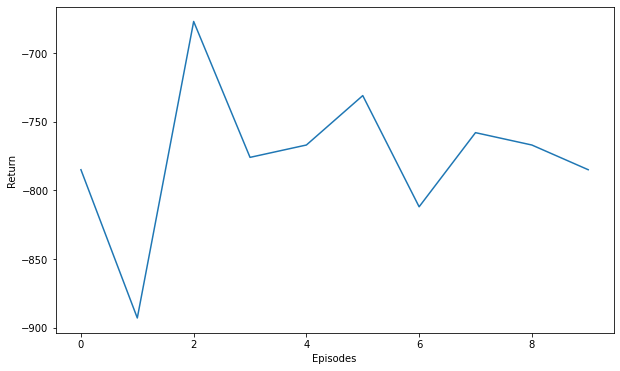

MoviePy - Building file videos/taxi.gif with imageio.


In [ ]:
# Create the environment
env = gym.make("Taxi-v3", render_mode='rgb_array_list')
recorder = GymRecorder(env)

# Create the agent
agent = RandomAgent(env)

# Train for 10 episodes
returns = agent.train(10, recorder)

plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.show()

video = "videos/taxi.gif"
recorder.make_video(video)
ipython_display(video)

**Pregunta 3:** ¿Que opina de los retornos? Concluya sobre la dificultad de la tarea.

Apliquemos control de Monte Carlo a este problema:

Repetir:

1. Generar un episodio usando la estrategia estocástica actual
2. Por cada par estado-acción visitado en el episodio actualizar el valor Q: $Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_t-Q(s_t,a_t))$
3. Por cada estado visitado actualizar la estrategia:

$\pi(s_t)= \begin{cases} a-\epsilon & \text{si }a=a^* \\ \frac{\epsilon}{|A|-1} & \text{en otro caso} \end{cases}$

Necesitaremos:


- Una tabla para almacenar los valores de Q (500,6).
- Un mecanismo $\epsilon$-greedy para seleccionar las acciones
- Un mecanismo que actualize los valores de Q

**Pregunta 3:** Cree una clase MonteCarloAgent que implemente control de Monte Carlo para el entorno Taxi.

Use $\gamma = 0.9$, $\epsilon = 0.1$ y $\alpha=0.01$ (pase estos parámetros al constructor y almacenar). Entrene al agente por 20000 episodios. Almacene el retorno y la cantidad de pasos de cada episodio en una lista. Cree los gráficos correspondientes.

El entorno debe ser creado sin GymRender (env = gym.make("Taxi-v3")).

Calcule los retornos partiendo en el último estado. Para iterar hacia atrás puede usar el operador reversed().

  

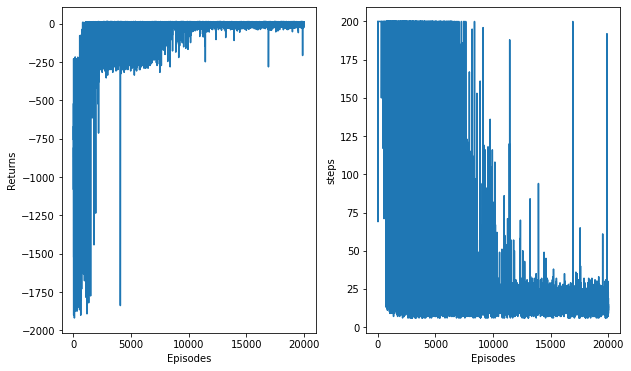

In [ ]:
class MonteCarloAgent:
    """
    Online Monte-Carlo agent.
    """

    def __init__(self, env, gamma, epsilon, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param epsilon: exploration parameter
        :param alpha: learning rate
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha

        # Q_table
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])

    def act(self, state):
        "Returns an action using epsilon-greedy action selection."

        action = rng.choice(np.where(self.Q[state, :] == self.Q[state, :].max())[0])

        if rng.random() < self.epsilon:
            action = self.env.action_space.sample()

        return action

    def update(self, episode):
        "Updates the agent using a complete episode."
        # Terminal states have a return of 0
        return_episode = 0.0

        # Iterate backwards over the episode
        for state, action, reward in reversed(episode):

            # Compute the return
            return_episode = reward + self.gamma * return_episode

            # Update the Q-value
            self.Q[state, action] += self.alpha * (return_episode - self.Q[state, action])


    def train(self, nb_episodes, recorder=False):
        """
        Runs the agent on the environment for nb_episodes. Returns the list of obtained returns and the number of steps.
        """

        # Returns and steps
        returns = []
        steps = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state, info = self.env.reset()
            return_episode = 0.
            nb_steps = 0

            # Store transitions
            transitions = []

            # Sample the episode
            done = False
            while not done:

                # Select an action
                action = self.act(state)

                # Perform the action
                next_state, reward, terminal, truncated, info = self.env.step(action)

                # Store the transition
                transitions.append([state, action, reward])

                # Go in the next state
                state = next_state

                # Terminal state
                done = terminal or truncated

                # Increment time
                nb_steps += 1
                return_episode += reward

            # Update the Monte Carlo agent after the episode is completed
            self.update(transitions)

            # Store info
            returns.append(return_episode)
            steps.append(nb_steps)


        return returns, steps

# Parameters
gamma = 0.9
epsilon = 0.1
alpha = 0.01
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgent(env, gamma, epsilon, alpha)

# Train the agent
returns, steps = agent.train(nb_episodes)


plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(returns)
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.subplot(122)
plt.plot(steps)
plt.xlabel("Episodes")
plt.ylabel("steps")
plt.show()

Los retornos tiene una varianza muy grande debido a la exploracion. Podemos mejorar el grafico si usamos un promedio de las ultimas N epocas:

In [ ]:
def running_average(x, N):
    cumsum = np.cumsum(np.insert(np.array(x), 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N

**Pregunta 4:** incluya el promedio en los gráficos anteriores. Comente sobre la influencia de la exploracion.


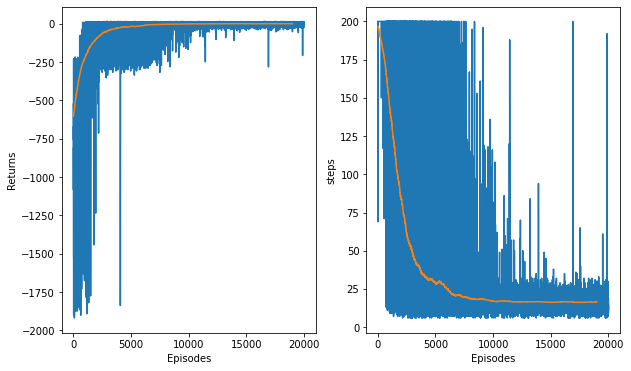

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.subplot(122)
plt.plot(steps)
plt.plot(running_average(steps, 1000))
plt.xlabel("Episodes")
plt.ylabel("steps")
plt.show()

**Pregunta 5** Extienda la clase con método test que ejecute un solo episodio sin exploración, que no aprenda.

Ejecute 1000 episodios de prueba y reporte el retorno promedio.

Sugerencia: Para no tener que volver a entrenar el agente simplemente transfiera los valores de Q del agente anterior:

test_agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)


test_agent.Q = agent.Q

return_episode, nb_steps = test_agent.test()

Test performance 5.558


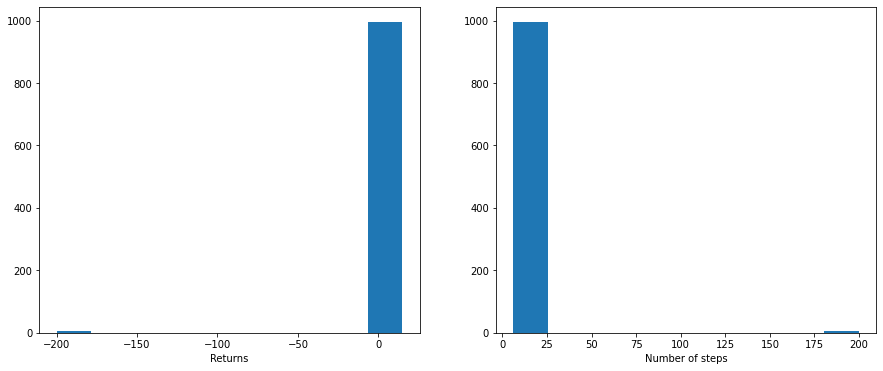

In [ ]:
class MonteCarloAgentTest (MonteCarloAgent):
    """
    Online Monte-Carlo agent with a test method.
    """

    def test(self, recorder=None):
        "Performs a test episode without exploration."
        # Set epsilon to 0
        previous_epsilon = self.epsilon
        self.epsilon = 0.0

        # Reset
        state, info = self.env.reset()
        done = False
        nb_steps = 0
        return_episode= 0

        # Sample the episode
        while not done:
            action = self.act(state)
            next_state, reward, terminal, truncated, info = self.env.step(action)
            return_episode += reward
            state = next_state
            done = terminal or truncated
            nb_steps += 1

        if recorder is not None:
            recorder.record(self.env.render())

        # Restore epsilon
        self.epsilon = previous_epsilon

        return return_episode, nb_steps

# Parameters
gamma = 0.9
epsilon = 0.1
alpha = 0.01
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
test_agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)
test_agent.Q = agent.Q


# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = test_agent.test()
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

# Preguntas adicionales

**Pregunta 6:** Entrene al agente solo hasta que el retorno parezca estable (por ejemplo 2000 episodios). Pruebe el agente. ¿Funciona? ¿Porque?

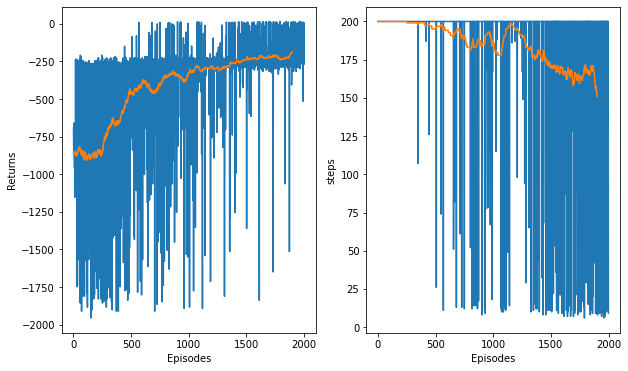

Test performance -172.729


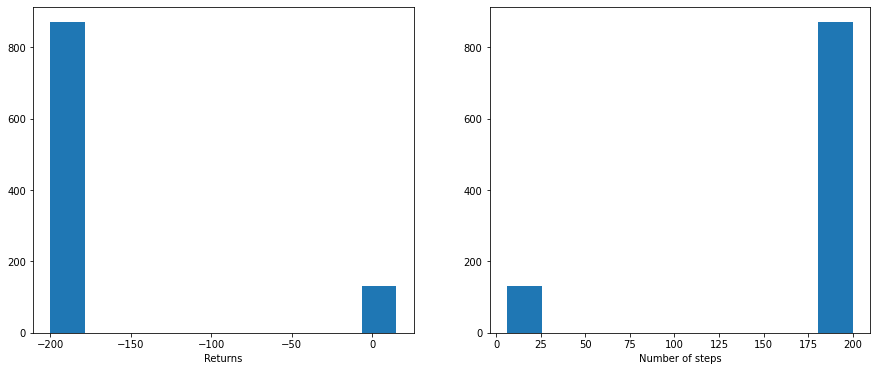

In [ ]:
# Parameters
gamma = 0.9
epsilon = 0.1
alpha = 0.01
nb_episodes = 2000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)

# Train the agent
returns, steps = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(returns)
plt.plot(running_average(returns, 100))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.subplot(122)
plt.plot(steps)
plt.plot(running_average(steps, 100))
plt.xlabel("Episodes")
plt.ylabel("steps")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test()
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

**Pregunta 7:** Cambie el valor del descuento $\gamma$. Como la tarea es episodica (maximo de 200 pases), pruebe un descuento de 1. ¿Que ocurre? Concluya.

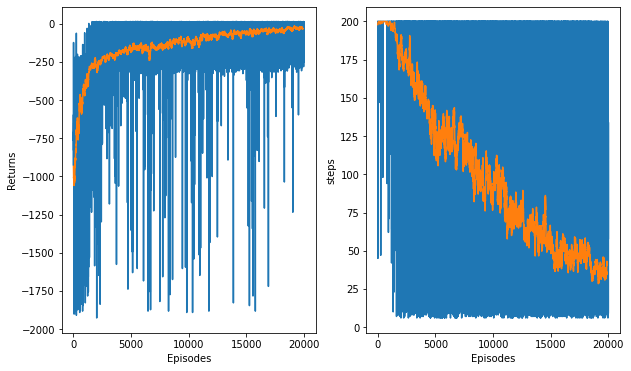

Test performance -43.218


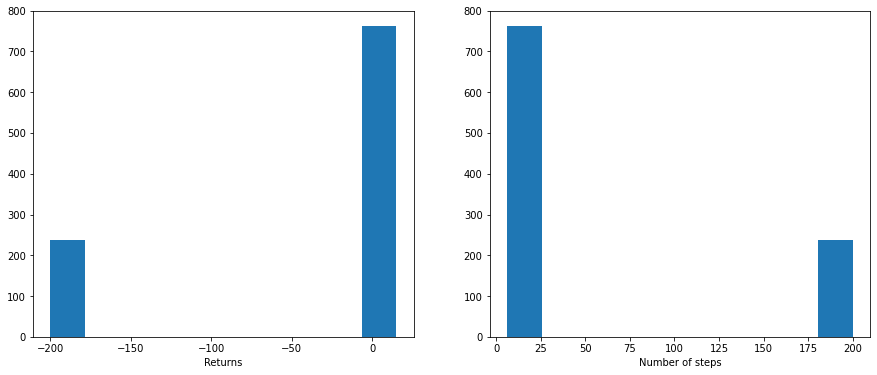

In [ ]:
# Parameters
gamma = 1.0
epsilon = 0.1
alpha = 0.01
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)

# Train the agent
returns, steps = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(returns)
plt.plot(running_average(returns, 100))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.subplot(122)
plt.plot(steps)
plt.plot(running_average(steps, 100))
plt.xlabel("Episodes")
plt.ylabel("steps")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test()
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

**Pregunta 8:** Cambie la tasa de aprendizaje alpha. ¿Que ocurre?

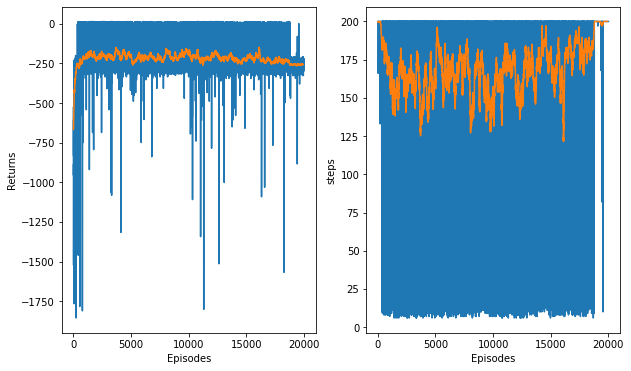

Test performance -200.0


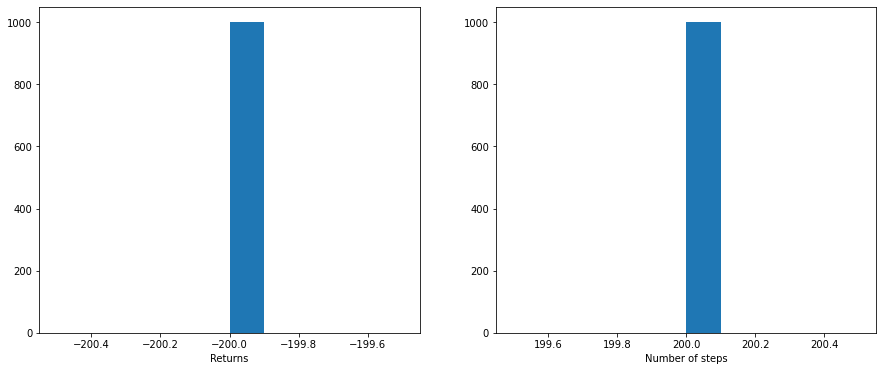

In [ ]:
# Parameters
gamma = 0.9
epsilon = 0.1
alpha = 0.5
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = MonteCarloAgentTest(env, gamma, epsilon, alpha)

# Train the agent
returns, steps = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(returns)
plt.plot(running_average(returns, 100))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.subplot(122)
plt.plot(steps)
plt.plot(running_average(steps, 100))
plt.xlabel("Episodes")
plt.ylabel("steps")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test()
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()